In [335]:
import importlib

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh_TGV1')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import Optics

import Graph

In [573]:
IR = Optics.Beam(w0=100e-6, lam=800e-9)

grid = IR.Grid(Lx=2e-4, Ly=2e-4, Nx=1000, Ny=1000)

M1 = np.array([IR.LGBeam(*grid, z=0, l=-2, p=0), 1j*IR.LGBeam(*grid, z=0, l=-2, p=0)])
M2 = np.array([IR.LGBeam(*grid, z=0, l=2, p=0), -1j*IR.LGBeam(*grid, z=0, l=2, p=0)])

M = M1+M2

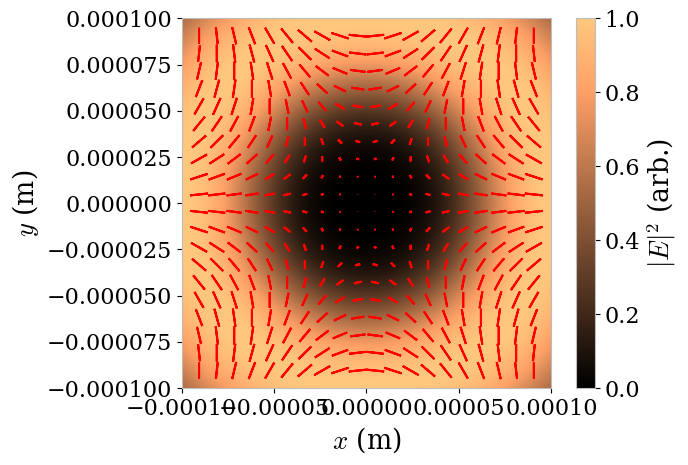

In [574]:
#importlib.reload(Graph)

test = Graph.EllipsePlot(*M, grid)

test.Plot(N_ell=20)

In [625]:
"NCHHG SIMULATION"
IR = Optics.Beam(w0=50e-6, lam=800e-9)
theta = 0.040 # rad
q = 11
XUV = Optics.Beam(w0=1, lam=IR.lam/q)

#grid = IR.Grid(Lx=1e-4, Ly=1e-4, Nx=1000, Ny=1000) #for plotting the focus
grid = XUV.FocusGrid(Lx=3*theta, Ly=3*theta, Nx=1000, Ny=1000, d=1) # for propagating

# The beams are of the form [Ex, Ey]
M1 = np.array([1*IR.LGBeam(*grid, z=0, l=0, p=0), 1*1j*IR.LGBeam(*grid, z=0, l=0, p=0)])
#M1 = np.array([1*IR.HGBeam(*grid, z=0, m=1, n=0), 0*IR.HGBeam(*grid, z=0, m=0, n=1)])

M2 = np.array([1*IR.LGBeam(*Optics.Tilt_beam(*grid, 0, theta), l=0, p=0), -1*1j*IR.LGBeam(*Optics.Tilt_beam(*grid, 0, theta), l=0, p=0)])
#M2 = np.array([0*IR.HGBeam(*grid, z=0, m=0, n=1), 0*IR.HGBeam(*grid, z=0, m=0, n=1)])

alpha=1
M = M1+alpha*M2

In [626]:
importlib.reload(Graph)
%matplotlib qt

test = Graph.EllipsePlot(*M, grid)

test.Plot(N_ell=50)

In [627]:
from HHG import ActiveGrating
TS = ActiveGrating(qeff=3.5)

"Response function for modelling an anisotropic HHG medium"
def response(A, phi, directions, w): # Amplitude, angle of ellipse, list of preferential directions, width of gaussian response
    S = 0
    for theta in directions:
        S += A*np.exp(-(phi-theta)**2/w**2)
    return S

def response2(A, phi, m):
    return A*(1+0.75*np.cos(2*m*phi))

In [628]:
m = 3
directions=[]
for i in range(-m, m):
    directions.append(i*np.pi/m)

#directions=[-np.pi, -3*np.pi/4, 0, np.pi/4]

# Harmonic near-field. The amplitude scales as E^qeff. The x and y components are always in phase, hence we take the phase of Ex as the phase.
NF = response(test.E, test.phi, directions, 0.4)
#NF=test.E
NF = response2(test.E, test.phi, m)

XUV_NF = TS.Hq_NearField(NF*np.exp(1j*np.angle(test.normEx)), q)
XUV_NFx, XUV_NFy = XUV_NF*np.abs(test.normEx)*np.sign(test.Rex), XUV_NF*np.abs(test.normEy)*np.sign(test.Rey) # x and y components of the harmonic NF

# Harmonic far-field
XUV_FFx, grid_FF = XUV.Fraunhofer(XUV_NFx, grid, d=1)
XUV_FFy, grid_FF = XUV.Fraunhofer(XUV_NFy, grid, d=1)
#XUV_FFx, XUV_FFy = XUV_FFx*np.exp(1j*np.angle(test.normEx)), XUV_FFy*np.exp(1j*np.angle(test.normEy))
XUV_FF = [XUV_FFx, XUV_FFy]

In [629]:
ellFF = Graph.EllipsePlot(*XUV_FF, grid_FF)
#ellFF.Plot(N_ell=100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, '$m=3,$ $q=11$')

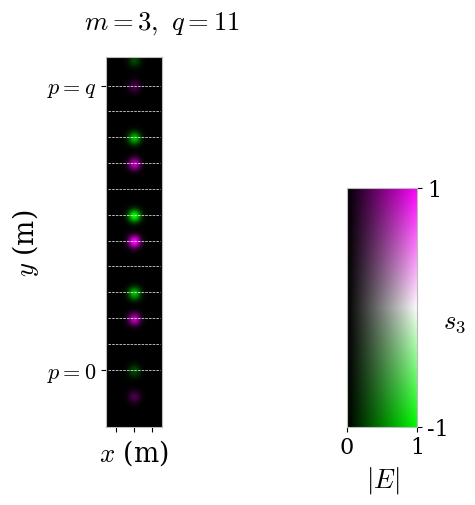

In [650]:
importlib.reload(Graph)
%matplotlib inline

fig, ax = Graph.s3_2D().ShowField_s3(field=ellFF.E, s3=ellFF.s3, grid=grid_FF, mode='Amplitude')

for p in range(0, q+1):
    ax[0].hlines(p*theta/q, -theta/q, theta/q, color='w', linestyle='dashed', linewidth=0.5)
#ax[0].grid()
ax[0].set_xlim(-theta/10, theta/10)
ax[0].set_ylim(-2*theta/10, 11*theta/10)
ax[0].set_yticks([0, theta], ["$p=0$", "$p=q$"])
ax[0].tick_params(labelleft=True)
fig.suptitle(r'$m='+str(m)+',$ $q='+str(q)+'$')